# Import libraries

In [11]:
import warnings
warnings.filterwarnings( 'ignore' )
# Basic libraries
import os
import pickle
import numpy    as np
import pandas   as pd
# Optuna library
import optuna
# XGBoost
import xgboost
# User libraries
from utils.Logger import *
from utils.utils import *
from utils.mlflow_logging import MLflow_log_performance
from utils.utils import copyDirTree

# Parameters

In [12]:
# Number of Optuna trials 
n_trials = 10
# Seed
seed = 42 
# Create logger
VERBOSE = True 
# Number of splits for Stratified Cross-Validation
n_splits = 5
# Hold-out percentage
test_size = 0.2

# Create temp directory for storing output figures
if not os.path.isdir('Performance'): os.mkdir('Performance')

In [13]:
# Initiate logger
if VERBOSE:
    logger = init_logger(log_file = 'logs.log') 

# Data

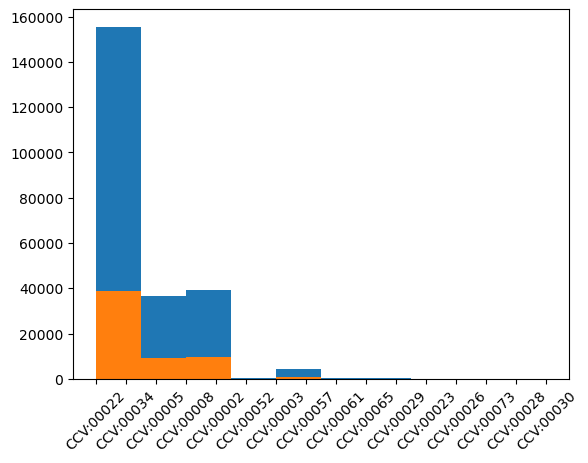

In [14]:
# Load data
X = np.load('Data/data.npz', allow_pickle=True)['X']
y = np.load('Data/data.npz', allow_pickle=True)['y']
if VERBOSE:
    logger.info('Data loaded')


# Split data (training/hold-out set)
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)
if VERBOSE:
    logger.info('Hold-out set is obtained')


# Class visualization
import matplotlib.pyplot as plt
plt.hist(trainY);
plt.hist(testY);
plt.xticks(rotation=45);


# Label encoding for targe class
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)
pickle.dump(le, open('label_encoder.sav', 'wb'))
# Get classes/labels
labels = list(le.classes_)
if VERBOSE:
    logger.info('Label encoding of target variable is performed')

# Hyperparameter optimization

In [15]:
# Initiate mlflow server
# Command: mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 127.0.0.1 --port 5000
# 
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("UC:GRE|Model:XGBoost")

if VERBOSE:
    logger.info('MLFlow server is connected')

2023/04/19 21:25:36 INFO mlflow.tracking.fluent: Experiment with name 'UC:GRE|Model:XGBoost' does not exist. Creating a new experiment.


## Prediction model

In [16]:
def objective(trial: optuna.trial.Trial) -> float: 
    # Logger
    if VERBOSE:
        logger.info(f'Trail: {trial.number} started [{trial.datetime_start}]')

    # Parameters
    params = {
        'n_estimators'      : trial.suggest_categorical('n_estimators', [500, 800]),
        'learning_rate'     : trial.suggest_categorical('learning_rate' , [1e-2, 5e-2, 1e-1]),
        'max_depth'         : trial.suggest_int('max_depth', 3, 6),
        'reg_alpha'         : 20, #trial.suggest_categorical('reg_alpha', [10, 20, 30]),
        'reg_lambda'        : 1.0, #trial.suggest_loguniform('reg_lambda', 0, 1),
        'gamma'             : 1, #trial.suggest_loguniform('gamma', 1 , 9),
        'min_child_weight'  : 2, #trial.suggest_int('min_child_weight', 2, 4),
        'max_leaves'        : 2, #trial.suggest_int('max_leaves', 2, 5),
    }


    # Setup model
    model = xgboost.XGBClassifier(objective           = 'multi:softmax',  
                                  n_jobs              = -1,                                   
                                  validate_parameters = True, 
                                  verbosity           = 1,
                                  tree_method         = 'hist',
                                  **params)
    
    # Cross-Validation
    train_CV_results, test_CV_results, CM_cv = cross_validation(model=model, X=trainX, Y=trainY, n_splits=n_splits, seed=seed, VERBOSE=VERBOSE)

    # Single-run 
    model, train_results, test_results, CM, predictions = single_run(model=model, trainX=trainX, trainY=trainY, testX=testX, testY=testY, VERBOSE=VERBOSE)

         
    if VERBOSE:
        logger.info(f'Trail: {trial.number} completed')

    # Include model signature
    signature = mlflow.models.infer_signature(testX, predictions)
    # Log performance to MLflow 
    MLflow_log_performance(trial.number, model, labels,
                           train_CV_results, test_CV_results, CM_cv, 
                           train_results, test_results, CM,
                           signature, params)

    # Copy artifacts
    copyDirTree('./artifacts', '../artifacts')
    
    if VERBOSE:
        logger.info(f'Trail: {trial.number} Performance metrics & model logged')

    return np.mean(test_CV_results['AUC'])

## Hyperparameter optimization process

In [17]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed = seed),
                           )

study.optimize(func=objective, 
               n_trials=n_trials, 
               n_jobs=1,)

[I 2023-04-19 21:25:36,362] A new study created in memory with name: no-name-7aa381f3-901f-4f43-8b5f-4b77c31bf1ee


[0]	validation_0-auc:0.77852	validation_1-auc:0.77652
[50]	validation_0-auc:0.90075	validation_1-auc:0.89902
[100]	validation_0-auc:0.92909	validation_1-auc:0.92792
[150]	validation_0-auc:0.94563	validation_1-auc:0.94482
[200]	validation_0-auc:0.95678	validation_1-auc:0.95618
[250]	validation_0-auc:0.96435	validation_1-auc:0.96389
[300]	validation_0-auc:0.96957	validation_1-auc:0.96916
[350]	validation_0-auc:0.97345	validation_1-auc:0.97307
[400]	validation_0-auc:0.97636	validation_1-auc:0.97599
[450]	validation_0-auc:0.97870	validation_1-auc:0.97835
[500]	validation_0-auc:0.98072	validation_1-auc:0.98038
[550]	validation_0-auc:0.98240	validation_1-auc:0.98207
[600]	validation_0-auc:0.98381	validation_1-auc:0.98349
[650]	validation_0-auc:0.98500	validation_1-auc:0.98468
[700]	validation_0-auc:0.98602	validation_1-auc:0.98571
[750]	validation_0-auc:0.98693	validation_1-auc:0.98662
[799]	validation_0-auc:0.98775	validation_1-auc:0.98744


[I 2023-04-19 22:21:13,962] Trial 0 finished with value: 0.9015652862306677 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 3}. Best is trial 0 with value: 0.9015652862306677.


[0]	validation_0-auc:0.77900	validation_1-auc:0.77698
[50]	validation_0-auc:0.96508	validation_1-auc:0.96460
[100]	validation_0-auc:0.98112	validation_1-auc:0.98077
[150]	validation_0-auc:0.98716	validation_1-auc:0.98685
[200]	validation_0-auc:0.99038	validation_1-auc:0.99007
[250]	validation_0-auc:0.99243	validation_1-auc:0.99213
[300]	validation_0-auc:0.99374	validation_1-auc:0.99344
[350]	validation_0-auc:0.99464	validation_1-auc:0.99434
[400]	validation_0-auc:0.99531	validation_1-auc:0.99502
[450]	validation_0-auc:0.99580	validation_1-auc:0.99552
[500]	validation_0-auc:0.99619	validation_1-auc:0.99592
[550]	validation_0-auc:0.99650	validation_1-auc:0.99623
[600]	validation_0-auc:0.99677	validation_1-auc:0.99651
[650]	validation_0-auc:0.99698	validation_1-auc:0.99672
[700]	validation_0-auc:0.99716	validation_1-auc:0.99691
[750]	validation_0-auc:0.99732	validation_1-auc:0.99708
[799]	validation_0-auc:0.99746	validation_1-auc:0.99722


[I 2023-04-19 23:03:24,980] Trial 1 finished with value: 0.917326184351867 and parameters: {'n_estimators': 800, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 1 with value: 0.917326184351867.


[0]	validation_0-auc:0.77950	validation_1-auc:0.77744
[50]	validation_0-auc:0.98158	validation_1-auc:0.98122
[100]	validation_0-auc:0.99048	validation_1-auc:0.99019
[150]	validation_0-auc:0.99379	validation_1-auc:0.99351
[200]	validation_0-auc:0.99534	validation_1-auc:0.99506
[250]	validation_0-auc:0.99622	validation_1-auc:0.99596
[300]	validation_0-auc:0.99679	validation_1-auc:0.99653
[350]	validation_0-auc:0.99718	validation_1-auc:0.99694
[400]	validation_0-auc:0.99748	validation_1-auc:0.99724
[450]	validation_0-auc:0.99772	validation_1-auc:0.99749
[499]	validation_0-auc:0.99791	validation_1-auc:0.99768


[I 2023-04-19 23:34:03,550] Trial 2 finished with value: 0.9156984933172989 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 5}. Best is trial 1 with value: 0.917326184351867.


[0]	validation_0-auc:0.77852	validation_1-auc:0.77652
[50]	validation_0-auc:0.90075	validation_1-auc:0.89902
[100]	validation_0-auc:0.92909	validation_1-auc:0.92792
[150]	validation_0-auc:0.94563	validation_1-auc:0.94482
[200]	validation_0-auc:0.95678	validation_1-auc:0.95618
[250]	validation_0-auc:0.96435	validation_1-auc:0.96389
[300]	validation_0-auc:0.96957	validation_1-auc:0.96916
[350]	validation_0-auc:0.97345	validation_1-auc:0.97307
[400]	validation_0-auc:0.97636	validation_1-auc:0.97599
[450]	validation_0-auc:0.97870	validation_1-auc:0.97835
[499]	validation_0-auc:0.98068	validation_1-auc:0.98034


[I 2023-04-20 00:02:47,674] Trial 3 finished with value: 0.8909654013727357 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 4}. Best is trial 1 with value: 0.917326184351867.


[0]	validation_0-auc:0.77950	validation_1-auc:0.77744
[50]	validation_0-auc:0.98158	validation_1-auc:0.98122
[100]	validation_0-auc:0.99048	validation_1-auc:0.99019
[150]	validation_0-auc:0.99379	validation_1-auc:0.99351
[200]	validation_0-auc:0.99534	validation_1-auc:0.99506
[250]	validation_0-auc:0.99622	validation_1-auc:0.99596
[300]	validation_0-auc:0.99679	validation_1-auc:0.99653
[350]	validation_0-auc:0.99718	validation_1-auc:0.99694
[400]	validation_0-auc:0.99748	validation_1-auc:0.99724
[450]	validation_0-auc:0.99772	validation_1-auc:0.99749
[500]	validation_0-auc:0.99791	validation_1-auc:0.99768
[550]	validation_0-auc:0.99808	validation_1-auc:0.99785
[600]	validation_0-auc:0.99821	validation_1-auc:0.99799
[650]	validation_0-auc:0.99832	validation_1-auc:0.99810
[700]	validation_0-auc:0.99843	validation_1-auc:0.99820
[750]	validation_0-auc:0.99851	validation_1-auc:0.99829
[799]	validation_0-auc:0.99859	validation_1-auc:0.99837


[I 2023-04-20 00:54:13,823] Trial 4 finished with value: 0.918853558700356 and parameters: {'n_estimators': 800, 'learning_rate': 0.1, 'max_depth': 3}. Best is trial 4 with value: 0.918853558700356.


[0]	validation_0-auc:0.77950	validation_1-auc:0.77744
[50]	validation_0-auc:0.98158	validation_1-auc:0.98122
[100]	validation_0-auc:0.99048	validation_1-auc:0.99019
[150]	validation_0-auc:0.99379	validation_1-auc:0.99351
[200]	validation_0-auc:0.99534	validation_1-auc:0.99506
[250]	validation_0-auc:0.99622	validation_1-auc:0.99596
[300]	validation_0-auc:0.99679	validation_1-auc:0.99653
[350]	validation_0-auc:0.99718	validation_1-auc:0.99694
[400]	validation_0-auc:0.99748	validation_1-auc:0.99724
[450]	validation_0-auc:0.99772	validation_1-auc:0.99749
[499]	validation_0-auc:0.99791	validation_1-auc:0.99768


[I 2023-04-20 01:40:26,862] Trial 5 finished with value: 0.9156984933172989 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 4 with value: 0.918853558700356.


[0]	validation_0-auc:0.77852	validation_1-auc:0.77652
[50]	validation_0-auc:0.90075	validation_1-auc:0.89902
[100]	validation_0-auc:0.92909	validation_1-auc:0.92792
[150]	validation_0-auc:0.94563	validation_1-auc:0.94482
[200]	validation_0-auc:0.95678	validation_1-auc:0.95618
[250]	validation_0-auc:0.96435	validation_1-auc:0.96389
[300]	validation_0-auc:0.96957	validation_1-auc:0.96916
[350]	validation_0-auc:0.97345	validation_1-auc:0.97307
[400]	validation_0-auc:0.97636	validation_1-auc:0.97599
[450]	validation_0-auc:0.97870	validation_1-auc:0.97835
[499]	validation_0-auc:0.98068	validation_1-auc:0.98034


[I 2023-04-20 02:30:30,872] Trial 6 finished with value: 0.8909654013727357 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 4}. Best is trial 4 with value: 0.918853558700356.


[0]	validation_0-auc:0.77900	validation_1-auc:0.77698
[50]	validation_0-auc:0.96508	validation_1-auc:0.96460
[100]	validation_0-auc:0.98112	validation_1-auc:0.98077
[150]	validation_0-auc:0.98716	validation_1-auc:0.98685
[200]	validation_0-auc:0.99038	validation_1-auc:0.99007
[250]	validation_0-auc:0.99243	validation_1-auc:0.99213
[300]	validation_0-auc:0.99374	validation_1-auc:0.99344
[350]	validation_0-auc:0.99464	validation_1-auc:0.99434
[400]	validation_0-auc:0.99531	validation_1-auc:0.99502
[450]	validation_0-auc:0.99580	validation_1-auc:0.99552
[500]	validation_0-auc:0.99619	validation_1-auc:0.99592
[550]	validation_0-auc:0.99650	validation_1-auc:0.99623
[600]	validation_0-auc:0.99677	validation_1-auc:0.99651
[650]	validation_0-auc:0.99698	validation_1-auc:0.99672
[700]	validation_0-auc:0.99716	validation_1-auc:0.99691
[750]	validation_0-auc:0.99732	validation_1-auc:0.99708
[799]	validation_0-auc:0.99746	validation_1-auc:0.99722


[I 2023-04-20 03:50:13,250] Trial 7 finished with value: 0.917326184351867 and parameters: {'n_estimators': 800, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 4 with value: 0.918853558700356.


[0]	validation_0-auc:0.77852	validation_1-auc:0.77652
[50]	validation_0-auc:0.90075	validation_1-auc:0.89902
[100]	validation_0-auc:0.92909	validation_1-auc:0.92792
[150]	validation_0-auc:0.94563	validation_1-auc:0.94482
[200]	validation_0-auc:0.95678	validation_1-auc:0.95618
[250]	validation_0-auc:0.96435	validation_1-auc:0.96389
[300]	validation_0-auc:0.96957	validation_1-auc:0.96916
[350]	validation_0-auc:0.97345	validation_1-auc:0.97307
[400]	validation_0-auc:0.97636	validation_1-auc:0.97599
[450]	validation_0-auc:0.97870	validation_1-auc:0.97835
[499]	validation_0-auc:0.98068	validation_1-auc:0.98034


[I 2023-04-20 04:40:08,719] Trial 8 finished with value: 0.8909654013727357 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 4 with value: 0.918853558700356.


[0]	validation_0-auc:0.77900	validation_1-auc:0.77698
[50]	validation_0-auc:0.96508	validation_1-auc:0.96460
[100]	validation_0-auc:0.98112	validation_1-auc:0.98077
[150]	validation_0-auc:0.98716	validation_1-auc:0.98685
[200]	validation_0-auc:0.99038	validation_1-auc:0.99007
[250]	validation_0-auc:0.99243	validation_1-auc:0.99213
[300]	validation_0-auc:0.99374	validation_1-auc:0.99344
[350]	validation_0-auc:0.99464	validation_1-auc:0.99434
[400]	validation_0-auc:0.99531	validation_1-auc:0.99502
[450]	validation_0-auc:0.99580	validation_1-auc:0.99552
[500]	validation_0-auc:0.99619	validation_1-auc:0.99592
[550]	validation_0-auc:0.99650	validation_1-auc:0.99623
[600]	validation_0-auc:0.99677	validation_1-auc:0.99651
[650]	validation_0-auc:0.99698	validation_1-auc:0.99672
[700]	validation_0-auc:0.99716	validation_1-auc:0.99691
[750]	validation_0-auc:0.99732	validation_1-auc:0.99708
[799]	validation_0-auc:0.99746	validation_1-auc:0.99722


[I 2023-04-20 05:59:53,098] Trial 9 finished with value: 0.917326184351867 and parameters: {'n_estimators': 800, 'learning_rate': 0.05, 'max_depth': 4}. Best is trial 4 with value: 0.918853558700356.


In [18]:
# Delete temp directory
import shutil
shutil.rmtree('Performance')
shutil.rmtree('artifacts')

### Visualization of the learning curves of the trials


In [19]:
optuna.visualization.plot_optimization_history(study)

### Visualization of hyperparameter relationships


In [20]:
optuna.visualization.plot_parallel_coordinate(study, params=[params for params in study.best_params])

### Hyperparameter importances


In [21]:
optuna.visualization.plot_param_importances(study, 
                                            target      = lambda t: t.duration.total_seconds(), 
                                            target_name = "duration")

### Get optimized hyperparameters

In [22]:
print('[INFO] Optimized hyperparameters\n')
for (parameter,value) in study.best_params.items():
    if ( isinstance(value, float) ):
        print(' >%25s: %.3f' % (parameter,value))
    else:
        print(' >%25s: %s' % (parameter,value))

[INFO] Optimized hyperparameters

 >             n_estimators: 800
 >            learning_rate: 0.100
 >                max_depth: 3
